# Calculate parameter error estimates from scipy.optimize results

Wu Sun

Last updated: 2018-04-10

This notebook shows how to conduct parameter error estimation for a `scipy.optimize` nonlinear regression. The results are validated with the R `nls` function.

In [1]:
"""Nonlinear regression parameter error estimates: Comparsion between scipy and R"""
import numpy as np
from numpy import random
from scipy import optimize
import matplotlib.pyplot as plt
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

plt.rcParams['figure.figsize'] = [6.4, 4.8]

## Function to optimize

In [2]:
def func(p, x):
    return p[0] * (1 - np.exp(-x + p[1]))


def resid_func(p, x, y):
    return p[0] * (1 - np.exp(-x + p[1])) - y


def jac_func(p, x):
    return np.vstack((1. - np.exp(-x + p[1]), -p[0] * np.exp(-x + p[1]))).T

In [3]:
# Create synthetic data with random errors
x_data = np.arange(0., 2.01, 0.01)
y_data = func([5., 0.05], x_data) + random.random(x_data.size)

## Scipy least_squares fit

In [4]:
params_guess = [3., 0.]
splsq_fit = optimize.least_squares(resid_func, params_guess, loss='linear',
                                   f_scale=1, args=(x_data, y_data))
# derived statistics
SSR = np.nansum(splsq_fit.fun ** 2)
var_y = np.var(y_data)
dof = y_data.size - 2
MSE = SSR / dof
RMSE = np.sqrt(MSE)
print('SSR = ', SSR)
print('variance of y data = ', var_y)
print('degree of freedom = ', dof)
print('estimated mean square error = ', MSE)
print('estimated root mean square error = ', RMSE)

# get parameter standard error estimates
neg_hess = np.dot(splsq_fit.jac.T, splsq_fit.jac)
inv_neg_hess = np.linalg.inv(neg_hess)
splsq_fit_params_se = np.sqrt(np.diagonal(inv_neg_hess)) * RMSE

# test scipy least squares jacobian
print('\nJ^T J for approximated jacobian:\n', np.dot(splsq_fit.jac.T, splsq_fit.jac))
jac = jac_func(splsq_fit.x, x_data)
print('\nJ^T J for analytically evaluated jacobian:\n', np.dot(jac.T, jac))

SSR =  16.2883284973
variance of y data =  1.70924027715
degree of freedom =  199
estimated mean square error =  0.0818508969716
estimated root mean square error =  0.286095957629

J^T J for approximated jacobian:
 [[   80.35053232  -209.13568101]
 [ -209.13568101  1363.0126805 ]]

J^T J for analytically evaluated jacobian:
 [[   80.3505324   -209.13568265]
 [ -209.13568265  1363.01270104]]


## Validation with R nls

In [5]:
# import R nls and other useful functions
rpy2.robjects.numpy2ri.activate()  # activate the numpy2R conversion
rnls = robjects.r['nls']
rcoef = robjects.r['coef']
rsummary = robjects.r['summary']
rnls_fit = rnls(
    'y_data ~ p0 * (1 - exp(-x_data + p1))',
    data=robjects.DataFrame({'x_data': x_data, 'y_data': y_data}),
    start=robjects.r('list(p0=3, p1=0)'), trace=False)
rnls_fit_params = np.array(rcoef(rnls_fit))

# show summary
rnls_fit_summary = rsummary(rnls_fit)
print(rnls_fit_summary)
# get accessible fields of the summary
# print(rsummary(rnls_fit).names)

# convert to python dictionary for access
rnls_fit_dict = dict(zip(rnls_fit_summary.names, list(rnls_fit_summary)))

# get parameter standard error estimates
rnls_fit_params_se = np.array(rnls_fit_dict['parameters'])[:, 1]

print('param. std. err., scipy least_squares(): \n', splsq_fit_params_se)
print('\nparam. std. err., R nls(): \n', rnls_fit_params_se)


Formula: y_data ~ p0 * (1 - exp(-x_data + p1))

Parameters:
    Estimate Std. Error t value Pr(>|t|)    
p0  5.515218   0.041182 133.922  < 2e-16 ***
p1 -0.050730   0.009999  -5.073 8.93e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2861 on 199 degrees of freedom

Number of iterations to convergence: 3 
Achieved convergence tolerance: 3.067e-06


param. std. err., scipy least_squares(): 
 [ 0.04118236  0.00999898]

param. std. err., R nls(): 
 [ 0.04118236  0.00999897]


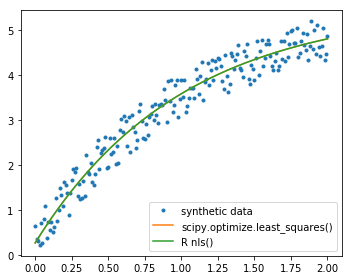

In [6]:
fig1, f1ax = plt.subplots(figsize=(5, 4))
f1ax.plot(x_data, y_data, '.', label='synthetic data')
f1ax.plot(x_data, func(splsq_fit.x, x_data), '-', label='scipy.optimize.least_squares()')
f1ax.plot(x_data, func(rnls_fit_params, x_data), '-', label='R nls()')
f1ax.legend(loc='best')
fig1.tight_layout()